# NLP (Natural Language Processing) with Python

In this kernel, we will discuss a higher level overview of the basics of Natural Language Processing, which basically consists of combining machine learning techniques with text, and using math and statistics to get that text in a format that the machine learning algorithms can understand!

## Import dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sms-spam-collection-dataset/spam.csv


# Exploratory Data Analysis
Let's check out some of the stats with some plots and the built-in methods in pandas!

In [2]:
messages = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding='latin-1')

In [3]:
#Displaying top five rows
messages.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
#remove unneccessary columns
messages = messages.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [5]:
#renaming columns names
messages.columns= ['label','message']

In [6]:
#basic descriptive stats
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [7]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

# Feature Engineering

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general

Let's make a new column to detect how long the text messages are:

In [8]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [9]:
sns.set()

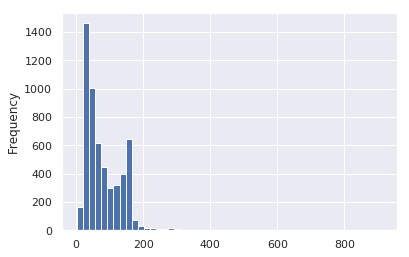

In [10]:
#Let's visualize this!
messages['length'].plot(bins=50, kind='hist');

Looks like text length may be a good feature to think about! Let's try to explain why the x-axis goes all the way to 1000ish, this must mean that there is some really long message!

In [11]:
messages.length.describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

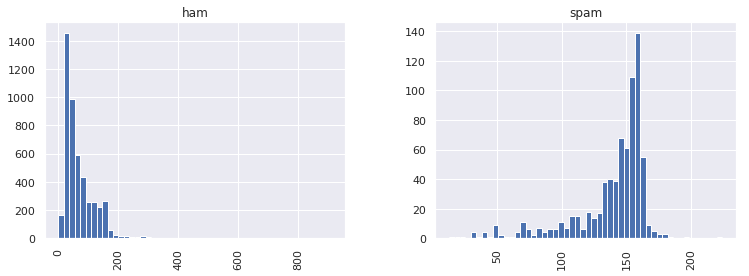

In [12]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4));

**Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters!!**

Now let's begin to process the data so we can eventually use it with SciKit Learn!**

## Text Pre-processing

In this kernel, we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

In [13]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

In [14]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [15]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [16]:
# Now just remove any stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [17]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Now let's put both of these together in a function to apply it to our DataFrame later on:

In [18]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

**Let's see an example output on on column:**

In [19]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

# Vectorization

Currently, we have the messages as lists of tokens and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11304


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [22]:
message4 = messages['message'][3]
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 3996)	2
  (0, 4551)	1
  (0, 5179)	1
  (0, 6118)	1
  (0, 6136)	1
  (0, 7091)	1
  (0, 9445)	2
(1, 11304)


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [23]:
messages_bow = bow_transformer.transform(messages['message'])
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11304)
Amount of Non-Zero occurences:  50193


In [24]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity,4)))

sparsity: 0.0797


# TF-IDF transformer


Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

Let's go ahead and see how we can do this in SciKit Learn:

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9445)	0.5391515179363724
  (0, 7091)	0.438375519235493
  (0, 6136)	0.3183143011307023
  (0, 6118)	0.2991551295536476
  (0, 5179)	0.2969195675145299
  (0, 4551)	0.26585776633899993
  (0, 3996)	0.40924708612713756


In [26]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.288863056423095
8.527076498901426


In [27]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11304)


There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit Learn's documentation on dealing with text data as well as the expansive collection of available papers and books on the general topic of NLP.

# Training a model

`We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [28]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [29]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected :', messages.label[3])

predicted: ham
expected : ham


Fantastic! We've developed a model that can attempt to predict spam vs ham classification!

# Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [30]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


We can use classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

In [31]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



## Train - Test split:

In [32]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572).

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [33]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [34]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f31d2c1e400>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [35]:
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.94      0.97      1015
        spam       0.62      1.00      0.77       100

    accuracy                           0.95      1115
   macro avg       0.81      0.97      0.87      1115
weighted avg       0.97      0.95      0.95      1115



Now we have a classification report for our model on a true testing set! There is a lot more to Natural Language Processing and its vast expanse of topic could fill up several college courses! Check out the resources below for more information on NLP!

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
accuracy_score(predictions,label_test) * 100

94.61883408071749

**Fantastic!!**
**Our model accuracy score is 96% which is quite awesome for my first NLP project**

We can improve our model by doing feature engg task such as stemming,lemmatization techniques!!!

## Improving Model performance (Apply stemming)

In [38]:
from nltk.stem.porter import PorterStemmer

In [39]:
#Stemming is the process of reducing words to its root words
port_stem  = PorterStemmer()
import re
from nltk.tokenize import word_tokenize

In [40]:
#Data cleaning and preprocessing
sms = []
for i in range(0,len(messages['message'])):
    review  = re.sub('[^a-zA-Z]',' ',messages['message'][i])
    review = review.lower()
    review = word_tokenize(review) #tokenization
    
    #stemming process
    
    review = [port_stem.stem(word) for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    sms.append(review)
    

In [41]:
#creating bag of words model
X = CountVectorizer(max_features=4000).fit_transform(sms) # limiting only 4000 features(columns)
y = messages.iloc[:,0]

In [42]:
#trian test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
#Fitting our model
spam_model = MultinomialNB()
spam_model.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [44]:
#Make Predictions
pred_stem = spam_model.predict(x_test)

We could have created pipeline workflow to ease our work!!

In [45]:
#Model evaluation 
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
print ( confusion_matrix(y_test,pred_stem))
print('\n')
print (classification_report(y_test,pred_stem))

[[1436   17]
 [  16  203]]


              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1453
        spam       0.92      0.93      0.92       219

    accuracy                           0.98      1672
   macro avg       0.96      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



In [46]:
#comparing results 
print ('Model accuracy score without stemming process :',accuracy_score(predictions,label_test) *int(100))
print('Model accuracy score with stemming : ',accuracy_score(y_test,pred_stem) *int(100)) 

Model accuracy score without stemming process : 94.61883408071749
Model accuracy score with stemming :  98.02631578947368


# Conclusion

Just by applying stemming process to our model,

**We increased our model performance by almost 1 percentage which is incredible!!**
Not only that,precision,f1_score has also increased significantly.

## More Resources

Check out the links below for more info on Natural Language Processing:

[NLTK Book Online](http://www.nltk.org/book/)

[Kaggle Walkthrough](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)

[SciKit Learn's Tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)